# RNNs to generate number sequences

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/storage/human_numbers/models'),
 PosixPath('/storage/human_numbers/train.txt'),
 PosixPath('/storage/human_numbers/valid.txt')]

In [4]:
def readnums(d):
    return [', '.join(t.strip() for t in open(path/d).readlines())]

In [5]:
train_txt = readnums('train.txt')
valid_txt = readnums('valid.txt')

In [6]:
train_txt[0][:81]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirte'

In [7]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

In [8]:
src = ItemLists(path=path, train=train, valid=valid).label_for_lm()

In [9]:
bs = 64
data = src.databunch(bs=bs)

In [10]:
len(data.valid_ds[0][0].data)

13017

In [11]:
data.bptt, len(data.valid_dl)

(70, 3)

In [12]:
 13017/70/bs

2.905580357142857

In [13]:
it = iter(data.train_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

In [14]:
x1.numel() + x2.numel() + x3.numel()

13440

In [15]:
x1[:, 0]

tensor([22, 21,  9, 24,  9, 27,  9,  9, 11,  9, 12, 17, 18, 27, 11, 23, 15, 13,
        13, 17, 11, 19, 10, 11, 10, 15,  9, 14, 11,  9, 11, 13, 10, 10, 21, 23,
         9, 15, 11, 11, 12, 13, 27, 16, 21, 17, 16, 16, 10, 11, 14, 10, 12, 18,
        11,  9, 18, 11, 18, 11, 10, 25, 18,  9], device='cuda:0')

In [16]:
voc = data.train_ds.vocab

In [17]:
voc.textify(x1[:, 0])

'thirty twenty , fifty , eighty , , thousand , one six seven eighty thousand forty four two two six thousand eight hundred thousand hundred four , three thousand , thousand two hundred hundred twenty forty , four thousand thousand one two eighty five twenty six five five hundred thousand three hundred one seven thousand , seven thousand seven thousand hundred sixty seven ,'

In [18]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight"
1,", eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine ,"
2,"thousand eighty seven , eight thousand eighty eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand"
3,"one hundred twenty three , eight thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one"
4,"two , eight thousand one hundred fifty three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two"


## Fully connected model

In [19]:
data = src.databunch(bs=bs, bptt=3)

In [20]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [21]:
nv = len(voc.itos); nv

40

In [22]:
nh = 64

In [23]:
def loss4(input, target): return F.cross_entropy(input, target[:, -1])

In [24]:
def acc4(input, target): return accuracy(input, target[:, -1])

In [65]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1]>1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1]>2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [66]:
learn = Learner(data, Model0().cuda(), loss_func=loss4, metrics=acc4)

In [27]:
x[:, 0].shape

torch.Size([64])

In [28]:
h = learn.model.i_h(x[:, 0].cuda())
h.shape

torch.Size([64, 64])

In [29]:
h = learn.model.h_h(h)
h.shape

torch.Size([64, 64])

In [30]:
res = learn.model.h_o(h)
res.shape

torch.Size([64, 40])

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,acc4,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


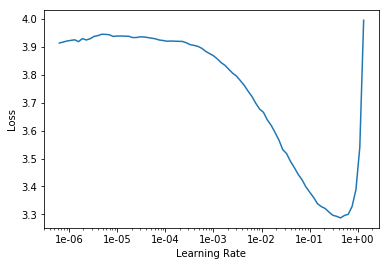

In [32]:
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.858082,3.837203,0.062500,00:00
1,3.797817,3.722738,0.071023,00:00
2,3.700317,3.606441,0.130682,00:00
3,3.603987,3.530923,0.159091,00:00
4,3.531893,3.498290,0.177557,00:00
5,3.490878,3.493155,0.177557,00:00


## Doing the same thing with a loop (see the _recursion_ now?)

In [34]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h += self.i_h(x[:, i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [35]:
learn = Learner(data, Model1().cuda(), loss_func=loss4, metrics=acc4)

In [36]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.546347,3.580090,0.053539,00:02
1,2.673393,2.742845,0.455423,00:02
2,2.098588,2.230286,0.463695,00:02
3,1.866805,2.064614,0.466912,00:01
4,1.785936,2.020458,0.467601,00:01
5,1.769346,2.015106,0.467831,00:02


## Lets maintain some state!

In [37]:
data = src.databunch(bs=bs, bptt=20)

In [38]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [47]:
    class Model3(nn.Module):
        def __init__(self):
            super().__init__()
            self.i_h = nn.Embedding(nv,nh)
            self.h_h = nn.Linear(nh,nh)
            self.h_o = nn.Linear(nh,nv)
            self.bn = nn.BatchNorm1d(nh)
            self.h = torch.zeros(bs, nh).cuda()

        def forward(self, x):
            res = []
            h = self.h
            for i in range(x.shape[1]):
                h = h + self.i_h(x[:,i])
                h = F.relu(self.h_h(h))
                res.append(self.bn(h))
#                 print(f"State of res: {len(res), res[0].shape}")
            self.h = h.detach()
            
            res = torch.stack(res, dim=1)
#             print(f"Stacked Res: {res.shape}")
            res = self.h_o(res)
            return res

In [48]:
learn = Learner(data, Model3().cuda(), metrics=acc4)

**Lets dig into this embedding magic a little**

-----

Showing the dimenstions of the embedding layer as 40, 64.
Our vocabulary has 40 elements, each of those are defined by a projection/vector of 64 numbers
Lets see what happens when we pass it input data of varying sizes

In [41]:
learn.model.i_h, learn.model.h_h, learn.model.h_o

(Embedding(40, 64),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=40, bias=True))

In [42]:
z_ = torch.stack([x[: ,1], x[: , 2]], dim=1).cuda()
z_1 = torch.cat([x[:, 1], x[:, 2]], dim=0).cuda()

**Shapes for z_ and z_1**

In [43]:
z_.shape, z_1.shape

(torch.Size([64, 2]), torch.Size([128]))

In [44]:
learn.model.i_h(z_)[0], learn.model.i_h(z_).shape

(tensor([[-1.2015, -0.2245, -1.4328, -0.5255,  0.1147, -1.5263,  1.1836,  0.2107,
          -1.8475,  2.1115,  2.0834,  1.3893,  0.7617, -0.5161, -0.5124,  0.9540,
           1.1879, -0.4222, -0.2558,  0.7644, -0.6173, -0.7073,  0.3403, -0.1924,
           0.4545,  0.3708,  0.2716,  0.6140, -2.2636, -0.6016,  0.3419,  0.5324,
          -1.7709,  0.2227,  0.4140,  1.3470,  0.0569, -1.2204, -0.4777,  0.9890,
           0.1619,  0.4562, -1.1818,  1.3985,  1.8758, -1.7593, -0.3778, -0.7189,
          -0.6486, -1.6745, -0.7432,  1.2443, -0.0682, -0.2141, -1.2768,  1.5361,
          -1.8507, -0.7885, -2.6609, -0.1939, -0.6087,  0.8305,  0.8201,  0.7781],
         [-0.5054, -0.7006, -1.3109, -0.8091,  0.2768,  0.6480, -0.3686, -0.1746,
          -0.4095, -0.5427,  1.6760,  0.0347,  0.3012, -0.5704,  0.7236,  0.0248,
          -0.1042,  1.0804,  0.1436, -0.5671, -0.7357,  2.3742, -0.6220, -2.2316,
          -1.1716,  0.7453,  0.7839,  1.1871, -2.9290,  0.8553, -0.2689,  0.7700,
          -0.23

In [45]:
learn.model.i_h(z_1), learn.model.i_h(z_1).shape

(tensor([[-1.2015, -0.2245, -1.4328,  ...,  0.8305,  0.8201,  0.7781],
         [ 0.5171, -0.4593, -1.2855,  ..., -0.9817, -0.3225, -0.2236],
         [-0.5054, -0.7006, -1.3109,  ...,  1.3437,  0.0392,  0.6211],
         ...,
         [ 1.8741,  0.8483, -1.8950,  ...,  0.8023, -1.2306,  0.5239],
         [-0.5054, -0.7006, -1.3109,  ...,  1.3437,  0.0392,  0.6211],
         [-0.5054, -0.7006, -1.3109,  ...,  1.3437,  0.0392,  0.6211]],
        device='cuda:0', grad_fn=<EmbeddingBackward>), torch.Size([128, 64]))

### How does this work

Vector is (64, ) is length within `x`
z_ is stacked with 2 of them vertically making its dims (2, 64). With the embedding lookup resulting in a tenor that is (2, 64, 64). Meaning the values in each (1, 64) z_ has been expanded to (1, 64, 64) seeing as each value is projected to 64 numbers

In [49]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,acc4,time
0,3.565606,3.386087,0.053125,00:00
1,3.005116,2.518003,0.090412,00:00
2,2.301179,2.079199,0.083807,00:01
3,1.859201,2.075770,0.083097,00:00
4,1.644547,2.104011,0.082812,00:00
5,1.536783,2.103887,0.087429,00:00
6,1.417915,1.828375,0.094886,00:00
7,1.273020,1.836944,0.101705,00:00
8,1.115801,1.925108,0.102202,00:00
9,0.976886,1.740990,0.107955,00:00


## Using the nn.RNN module

In [59]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [60]:
learn = Learner(data, Model4(), metrics=acc4)

In [61]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,acc4,time
0,3.516092,3.334538,0.056605,00:00
1,2.820313,2.287833,0.093892,00:00
2,2.134635,2.015627,0.094602,00:00
3,1.771499,2.085314,0.099787,00:00
4,1.599676,2.086438,0.096307,00:00
5,1.481168,1.786862,0.099219,00:00
6,1.307530,1.712583,0.106179,00:00
7,1.115963,1.493273,0.103622,00:00
8,0.950515,1.404782,0.109801,00:00
9,0.810414,1.371923,0.109517,00:00


In [62]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [63]:
learn = Learner(data, Model5(), metrics=accuracy)

In [64]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.707423,2.274937,0.472585,00:00
1,1.567244,1.285911,0.662003,00:00
2,0.751607,1.046251,0.769673,00:00
3,0.366991,1.091565,0.809233,00:00
4,0.186349,1.145596,0.812784,00:00
5,0.099514,1.262555,0.807244,00:00
6,0.056218,1.281823,0.811293,00:00
7,0.033780,1.252967,0.818040,00:00
8,0.021892,1.317860,0.814702,00:00
9,0.015658,1.311111,0.812500,00:00
